In [1]:
%load_ext autoreload
%autoreload 2

from models import MaskedTimeSeriesTransformer
import torch
model = MaskedTimeSeriesTransformer()
ckpt = torch.load("/net/tscratch/people/plgfimpro/korelacje/models/masked_m1_in100_out10.pt")
model.load_state_dict(ckpt["model_state_dict"])

from utils import load_multiple_files
from pathlib import Path
train_X, train_Y, test_X, test_Y = load_multiple_files(month = 1, root =  Path("/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2"), input_length=100, output_length=10)


In [2]:
from utils import TimeSeriesDataset
from torch.utils.data import DataLoader
train_dataset = TimeSeriesDataset(train_X, train_Y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TimeSeriesDataset(test_X, test_Y)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [14]:
def evaluate(model, dataloader, device, mask_mom = False, mask_child = False, autoregressive = False):
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in dataloader:
            src, tgt = batch
            src = src.to(device)
            tgt = tgt.to(device)

            # split src
            child_src = src[..., :2]
            mom_src = src[..., 2:]

            # split tgt
            child_tgt = tgt[..., :2]
            mom_tgt = tgt[..., 2:]
            if autoregressive:
                # ONE forward pass
                pred = model.forward_autoregressive(
                    child_src=child_src,
                    mom_src=mom_src,
                    mask_mom=mask_mom,
                    mask_child=mask_child,
                    tgt_len = mom_tgt.shape[-2]
                )
            else:
                pred = model(
                    child_src=child_src,
                    mom_src=mom_src,
                    child_tgt=child_tgt,
                    mom_tgt=mom_tgt,
                    mask_mom=mask_mom,
                    mask_child=mask_child
                )
                

            all_preds.append(pred.cpu())
            all_targets.append(tgt.cpu())

    all_preds = torch.cat(all_preds, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    return all_preds, all_targets

In [6]:
from torch.nn import functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
preds, targets = evaluate(model, test_loader, device, mask_mom=False, mask_child=True)

mse = F.mse_loss(preds, targets)
mae = F.l1_loss(preds, targets)

print(f"MSE: {mse.item():.4f}")
print(f"MAE: {mae.item():.4f}")

MSE: 0.5686
MAE: 0.5171


In [23]:

from utils import TimeSeriesDataset
from torch.utils.data import DataLoader
from utils import load_multiple_files
from pathlib import Path

def evaluate_model(month: int, input_length: int, output_length: int, autoregressive: bool = False, test_loader=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Evaluating (fixed) month={month} in={input_length} out={output_length}")
    if not test_loader:
        train_X, train_Y, test_X, test_Y = load_multiple_files(month=month, root= Path("/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2"), input_length=input_length, output_length=output_length)

        test_dataset = TimeSeriesDataset(test_X, test_Y)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print("testloader ready")
    model = MaskedTimeSeriesTransformer()
    ckpt = torch.load(f"/net/tscratch/people/plgfimpro/korelacje/models_fixed/masked_m{month}_in{input_length}_out{output_length}.pt")
    model.load_state_dict(ckpt["model_state_dict"])
    model.to(device)

    # evaluate combinations and compute loss only on the non-masked person's outputs
    for mask_mom, mask_child in [(False, False),(True, False),(False, True)]:
        preds, targets = evaluate(model, test_loader, device, mask_mom=mask_mom, mask_child=mask_child, autoregressive=autoregressive)
        # select non-masked indices: child -> :2, mom -> 2:
        if mask_mom and not mask_child:
            pred_sel = preds[..., :2]
            targ_sel = targets[..., :2]
            who = 'child'
            mse = F.mse_loss(pred_sel, targ_sel)
            mae = F.l1_loss(pred_sel, targ_sel)
            print(f"mask_mom={mask_mom}, mask_child={mask_child} -> loss on {who}: MSE={mse.item():.4f}, MAE={mae.item():.4f}")
        elif mask_child and not mask_mom:
            pred_sel = preds[..., 2:]
            targ_sel = targets[..., 2:]
            who = 'mom'
            mse = F.mse_loss(pred_sel, targ_sel)
            mae = F.l1_loss(pred_sel, targ_sel)
            print(f"mask_mom={mask_mom}, mask_child={mask_child} -> loss on {who}: MSE={mse.item():.4f}, MAE={mae.item():.4f}")
        else:
            pred_sel = preds[..., 2:]
            targ_sel = targets[..., 2:]
            who = 'mom'
            mse = F.mse_loss(pred_sel, targ_sel)
            mae = F.l1_loss(pred_sel, targ_sel)
            print(f"mask_mom={mask_mom}, mask_child={mask_child} -> loss on {who}: MSE={mse.item():.4f}, MAE={mae.item():.4f} (with both unmasked)")
            pred_sel = preds[..., :2]
            targ_sel = targets[..., :2]
            who = 'child'
            mse = F.mse_loss(pred_sel, targ_sel)
            mae = F.l1_loss(pred_sel, targ_sel)
            print(f"mask_mom={mask_mom}, mask_child={mask_child} -> loss on {who}: MSE={mse.item():.4f}, MAE={mae.item():.4f} (with both unmasked)")


In [15]:
def evaluate_model_fixed(month: int, input_length: int, output_length: int, test_loader=None, autoregressive: bool = False):
    """Evaluate model trained by train_masked_fixed.py. When a mask flag is True, compute loss only on the non-masked person's outputs."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Evaluating (fixed) month={month} in={input_length} out={output_length}")
    if not test_loader:
        train_X, train_Y, test_X, test_Y = load_multiple_files(month=month, root= Path("/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2"), input_length=input_length, output_length=output_length)

        test_dataset = TimeSeriesDataset(test_X, test_Y)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print("testloader ready")
    model = MaskedTimeSeriesTransformer()
    ckpt = torch.load(f"/net/tscratch/people/plgfimpro/korelacje/models_fixed/masked_m{month}_in{input_length}_out{output_length}.pt")
    model.load_state_dict(ckpt["model_state_dict"])
    model.to(device)

    # evaluate combinations and compute loss only on the non-masked person's outputs
    for mask_mom, mask_child in [(False, False),(True, False),(False, True)]:
        preds, targets = evaluate(model, test_loader, device, mask_mom=mask_mom, mask_child=mask_child, autoregressive=autoregressive)
        # select non-masked indices: child -> :2, mom -> 2:
        if mask_mom and not mask_child:
            pred_sel = preds[..., :2]
            targ_sel = targets[..., :2]
            who = 'child'
            mse = F.mse_loss(pred_sel, targ_sel)
            mae = F.l1_loss(pred_sel, targ_sel)
            print(f"mask_mom={mask_mom}, mask_child={mask_child} -> loss on {who}: MSE={mse.item():.4f}, MAE={mae.item():.4f}")
        elif mask_child and not mask_mom:
            pred_sel = preds[..., 2:]
            targ_sel = targets[..., 2:]
            who = 'mom'
            mse = F.mse_loss(pred_sel, targ_sel)
            mae = F.l1_loss(pred_sel, targ_sel)
            print(f"mask_mom={mask_mom}, mask_child={mask_child} -> loss on {who}: MSE={mse.item():.4f}, MAE={mae.item():.4f}")
        else:
            pred_sel = preds[..., 2:]
            targ_sel = targets[..., 2:]
            who = 'mom'
            mse = F.mse_loss(pred_sel, targ_sel)
            mae = F.l1_loss(pred_sel, targ_sel)
            print(f"mask_mom={mask_mom}, mask_child={mask_child} -> loss on {who}: MSE={mse.item():.4f}, MAE={mae.item():.4f} (with both unmasked)")
            pred_sel = preds[..., :2]
            targ_sel = targets[..., :2]
            who = 'child'
            mse = F.mse_loss(pred_sel, targ_sel)
            mae = F.l1_loss(pred_sel, targ_sel)
            print(f"mask_mom={mask_mom}, mask_child={mask_child} -> loss on {who}: MSE={mse.item():.4f}, MAE={mae.item():.4f} (with both unmasked)")

# Example smoke test (adjust month/in/out as needed)
#evaluate_model_fixed(month=1, input_length=100, output_length=10)

In [16]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(model, dataloader, device, num_examples=4, which_person='all', seed=42, autoregressive=False):
    """Plot `num_examples` prediction vs target traces from `dataloader` using `model`.
    `which_person` can be 'child', 'mom', or 'all'."""
    model.eval()
    preds, targets = evaluate(model, dataloader, device, mask_mom=False, mask_child=False, autoregressive=autoregressive)
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()
    n = preds.shape[0]
    if n == 0:
        print('No examples to plot')
        return
    rng = np.random.RandomState(seed)
    if n >= num_examples:
        idxs = np.linspace(0, n - 1, num_examples, dtype=int)
    else:
        idxs = np.arange(n)

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    for i, ax in enumerate(axes[:len(idxs)]):
        idx = idxs[i]
        p = preds[idx]  # shape (out_len, features)
        t = targets[idx]
        x = np.arange(p.shape[0])
        # child dims are [:2], mom dims are [2:]
        if which_person in ('child', 'all'):
            ax.plot(x, t[:, 0], 'k-', label='child_true_x' if i == 0 else None)
            ax.plot(x, p[:, 0], 'k--', label='child_pred_x' if i == 0 else None)
            ax.plot(x, t[:, 1], 'b-', label='child_true_y' if i == 0 else None)
            ax.plot(x, p[:, 1], 'b--', label='child_pred_y' if i == 0 else None)
        if which_person in ('mom', 'all'):
            ax.plot(x, t[:, 2], 'g-', label='mom_true_x' if i == 0 else None)
            ax.plot(x, p[:, 2], 'g--', label='mom_pred_x' if i == 0 else None)
            ax.plot(x, t[:, 3], 'r-', label='mom_true_y' if i == 0 else None)
            ax.plot(x, p[:, 3], 'r--', label='mom_pred_y' if i == 0 else None)
        ax.set_title(f'Example index {idx}')
        ax.set_xlabel('timestep')
    # Collect legend from first axis that has handles
    for ax in axes:
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            fig.legend(handles, labels, loc='upper right')
            break
    plt.tight_layout()
    plt.show()


In [10]:
train_X100_10, train_Y100_10, test_X100_10, test_Y100_10 = load_multiple_files(month = 1, root =  Path("/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2"), input_length=100, output_length=10)
train_dataset100_10 = TimeSeriesDataset(train_X100_10, train_Y100_10)
train_loader = DataLoader(train_dataset100_10, batch_size=32, shuffle=True)

test_dataset100_10 = TimeSeriesDataset(test_X100_10, test_Y100_10)
test_loader100_10 = DataLoader(test_dataset100_10, batch_size=32, shuffle=False)

In [11]:
train_X100_50, train_Y100_50, test_X100_50, test_Y100_50 = load_multiple_files(month = 1, root =  Path("/net/tscratch/people/plgfimpro/korelacje/short_fixed_results_openface2"), input_length=100, output_length=50)
train_dataset100_50 = TimeSeriesDataset(train_X100_50, train_Y100_50)
train_loader = DataLoader(train_dataset100_50, batch_size=32, shuffle=True)

test_dataset100_50 = TimeSeriesDataset(test_X100_50, test_Y100_50)
test_loader100_50 = DataLoader(test_dataset100_50, batch_size=32, shuffle=False)


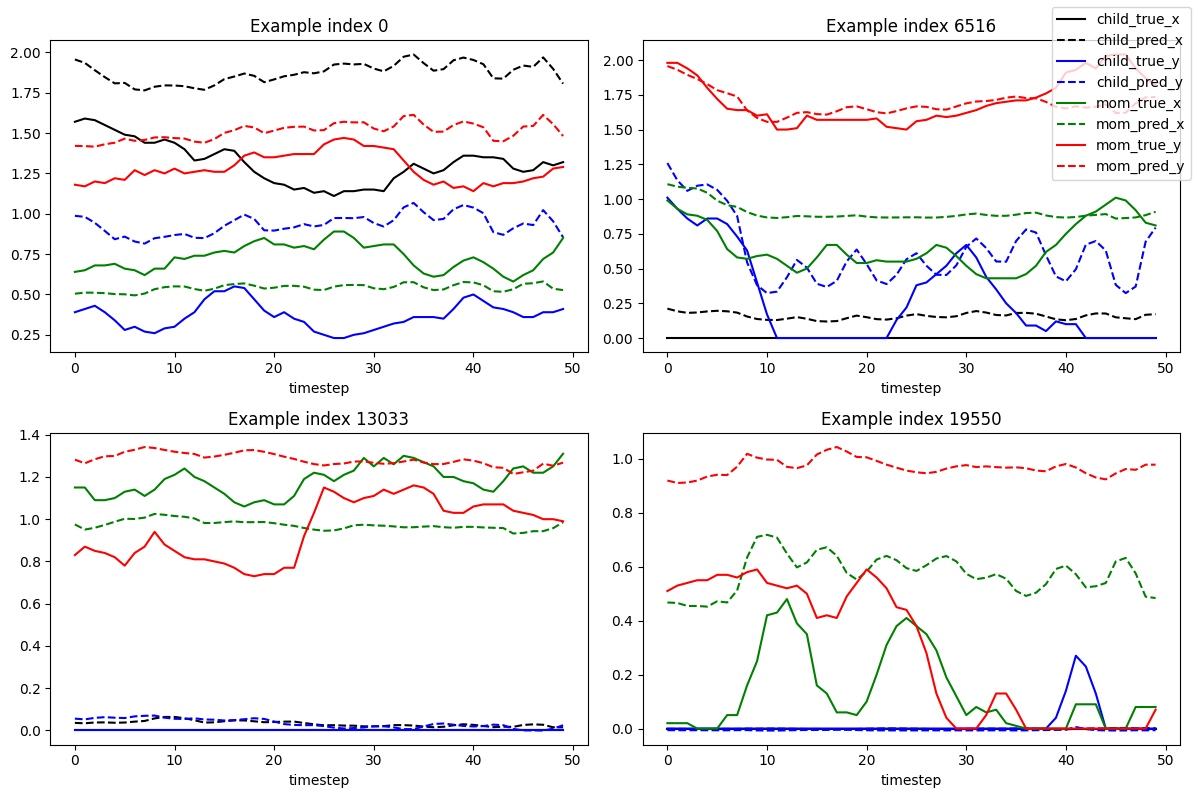

In [17]:
model = MaskedTimeSeriesTransformer()
ckpt = torch.load("/net/tscratch/people/plgfimpro/korelacje/models/masked_m1_in100_out10.pt")
model.load_state_dict(ckpt["model_state_dict"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
plot_predictions(model, test_loader100_50, device, num_examples=4, which_person='all')

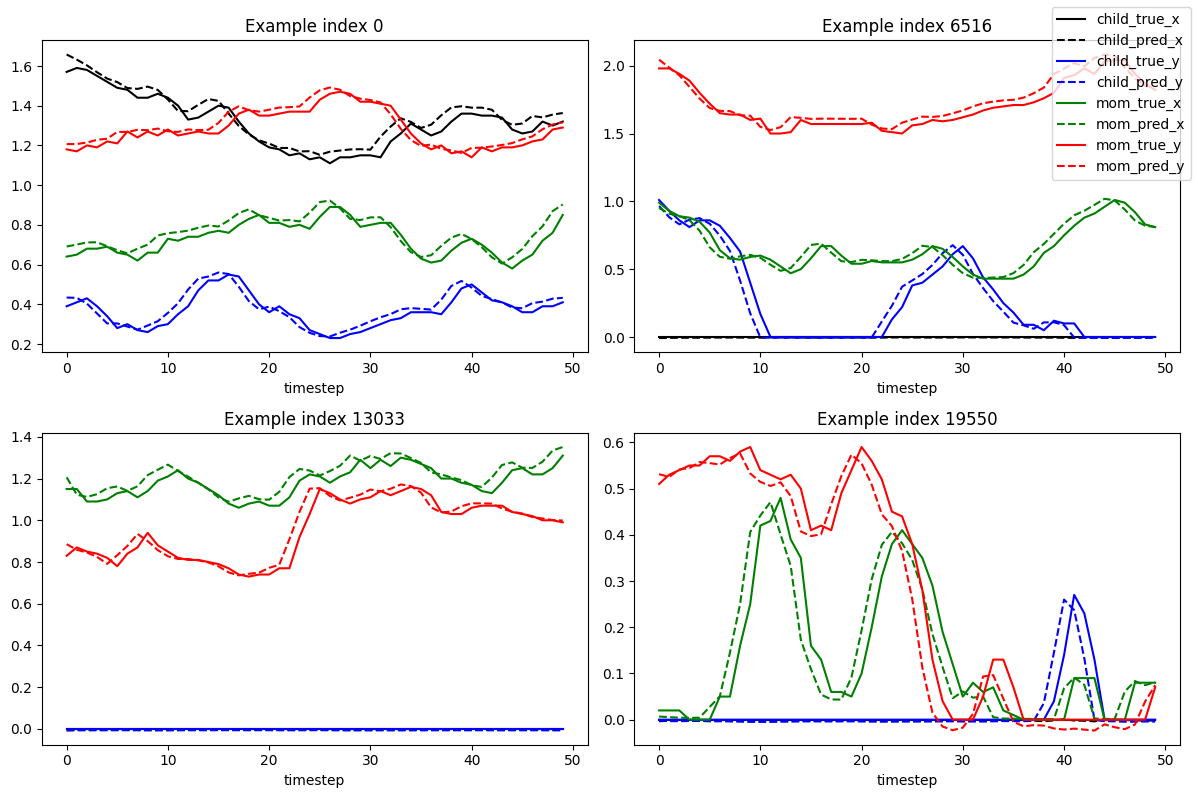

In [18]:
model = MaskedTimeSeriesTransformer()
ckpt = torch.load("/net/tscratch/people/plgfimpro/korelacje/models_fixed/masked_m1_in100_out50.pt")
model.load_state_dict(ckpt["model_state_dict"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
plot_predictions(model, test_loader100_50, device, num_examples=4, which_person='all')

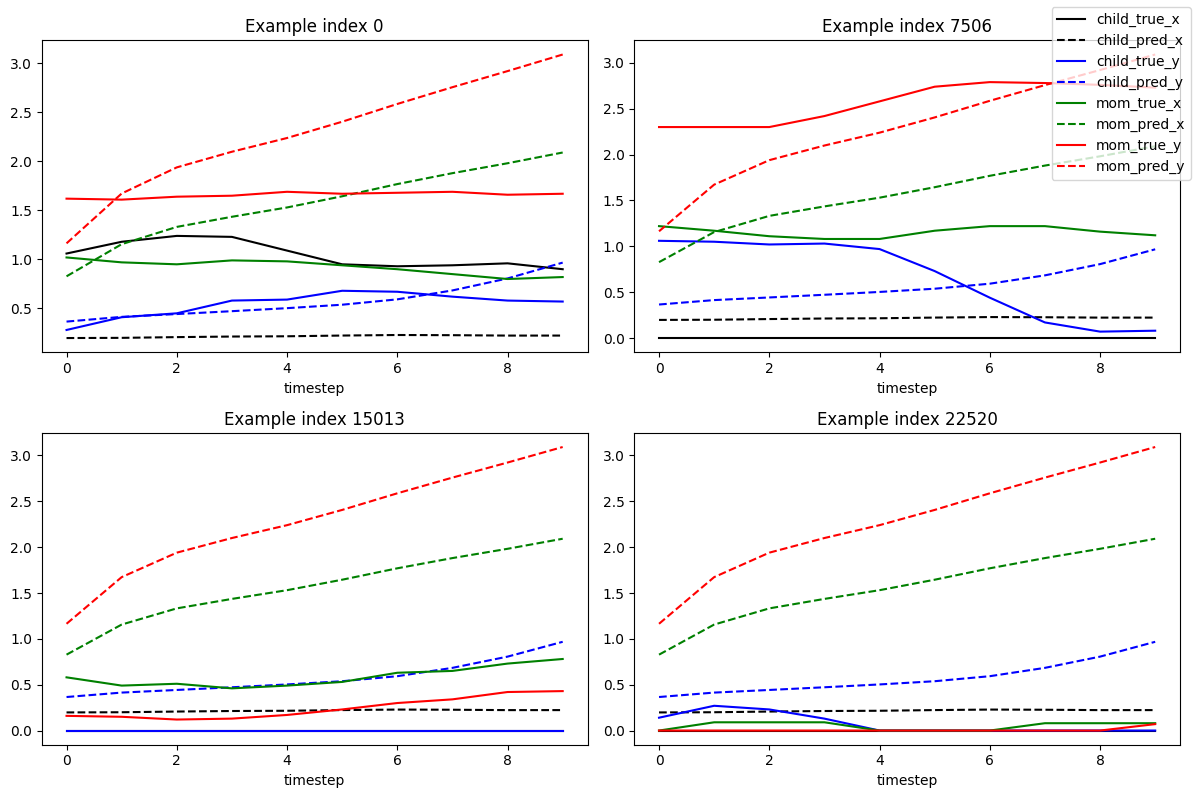

In [19]:
model = MaskedTimeSeriesTransformer()
ckpt = torch.load("/net/tscratch/people/plgfimpro/korelacje/models/masked_m1_in100_out10.pt")
model.load_state_dict(ckpt["model_state_dict"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
plot_predictions(model, test_loader100_10, device, num_examples=4, which_person='all', autoregressive=True)

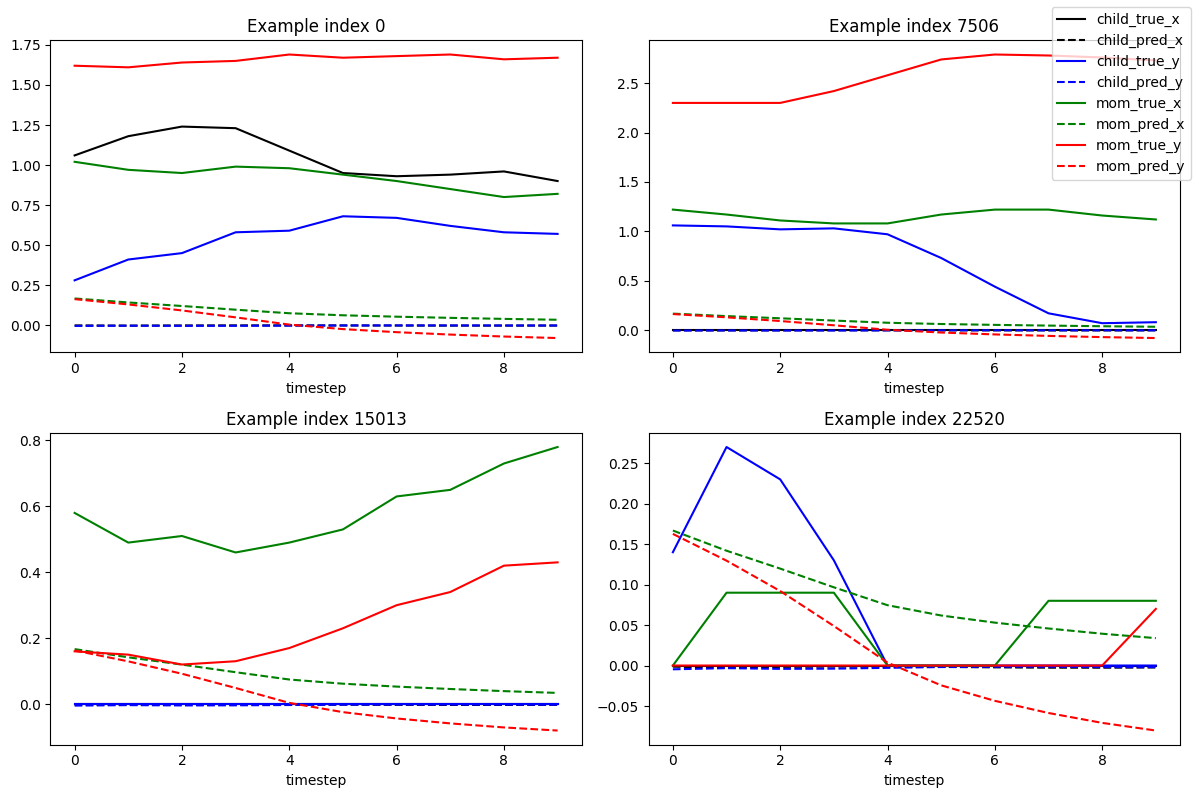

In [20]:
model = MaskedTimeSeriesTransformer()
ckpt = torch.load("/net/tscratch/people/plgfimpro/korelacje/models_fixed/masked_m1_in100_out50.pt")
model.load_state_dict(ckpt["model_state_dict"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
plot_predictions(model, test_loader100_10, device, num_examples=4, which_person='all', autoregressive=True)

In [27]:
len(train_loader)

2444

In [24]:
params_to_evaluate = [
    #(1, 100, 10),
   # (2, 100, 10),
    #(4, 100, 10),
    (1,100,25),
    (2,100,25),
    (4,100,25),
   # (1,100,50),
    #(2,100,50),
   # (4,100,50),
    #(1,200,10),
   # (2,200,10),
   # (4,200,10),
    (1,200,25),
    (2,200,25),
    (4,200,25),
   # (1,200,50),
   # (2,200,50),
   # (4,200,50),
]
for month, in_len, out_len in params_to_evaluate:
    evaluate_model(month, in_len, out_len)

Evaluating (fixed) month=1 in=100 out=25
testloader ready
mask_mom=False, mask_child=False -> loss on mom: MSE=0.0025, MAE=0.0332 (with both unmasked)
mask_mom=False, mask_child=False -> loss on child: MSE=0.0026, MAE=0.0259 (with both unmasked)
mask_mom=True, mask_child=False -> loss on child: MSE=0.0026, MAE=0.0252
mask_mom=False, mask_child=True -> loss on mom: MSE=0.0026, MAE=0.0332
Evaluating (fixed) month=2 in=100 out=25
testloader ready
mask_mom=False, mask_child=False -> loss on mom: MSE=0.0022, MAE=0.0305 (with both unmasked)
mask_mom=False, mask_child=False -> loss on child: MSE=0.0021, MAE=0.0239 (with both unmasked)
mask_mom=True, mask_child=False -> loss on child: MSE=0.0024, MAE=0.0249
mask_mom=False, mask_child=True -> loss on mom: MSE=0.0022, MAE=0.0306
Evaluating (fixed) month=4 in=100 out=25
testloader ready
mask_mom=False, mask_child=False -> loss on mom: MSE=0.0030, MAE=0.0331 (with both unmasked)
mask_mom=False, mask_child=False -> loss on child: MSE=0.0020, MAE=0.

In [25]:
params_to_evaluate = [
    #(1, 100, 10),
   # (2, 100, 10),
    #(4, 100, 10),
    (1,100,25),
    (2,100,25),
    (4,100,25),
   # (1,100,50),
    #(2,100,50),
   # (4,100,50),
    #(1,200,10),
   # (2,200,10),
   # (4,200,10),
    (1,200,25),
    (2,200,25),
    (4,200,25),
   # (1,200,50),
   # (2,200,50),
   # (4,200,50),
]
for month, in_len, out_len in params_to_evaluate:
    evaluate_model_fixed(month, in_len, out_len)

Evaluating (fixed) month=1 in=100 out=25
testloader ready
mask_mom=False, mask_child=False -> loss on mom: MSE=0.0025, MAE=0.0332 (with both unmasked)
mask_mom=False, mask_child=False -> loss on child: MSE=0.0026, MAE=0.0259 (with both unmasked)
mask_mom=True, mask_child=False -> loss on child: MSE=0.0026, MAE=0.0252
mask_mom=False, mask_child=True -> loss on mom: MSE=0.0026, MAE=0.0332
Evaluating (fixed) month=2 in=100 out=25
testloader ready
mask_mom=False, mask_child=False -> loss on mom: MSE=0.0022, MAE=0.0305 (with both unmasked)
mask_mom=False, mask_child=False -> loss on child: MSE=0.0021, MAE=0.0239 (with both unmasked)
mask_mom=True, mask_child=False -> loss on child: MSE=0.0024, MAE=0.0249
mask_mom=False, mask_child=True -> loss on mom: MSE=0.0022, MAE=0.0306
Evaluating (fixed) month=4 in=100 out=25
testloader ready
mask_mom=False, mask_child=False -> loss on mom: MSE=0.0030, MAE=0.0331 (with both unmasked)
mask_mom=False, mask_child=False -> loss on child: MSE=0.0020, MAE=0.

In [ ]:
params_to_evaluate = [
    #(1, 100, 10),
   # (2, 100, 10),
    #(4, 100, 10),
    (1,100,25),
    (2,100,25),
    (4,100,25),
   # (1,100,50),
    #(2,100,50),
   # (4,100,50),
    #(1,200,10),
   # (2,200,10),
   # (4,200,10),
    (1,200,25),
    (2,200,25),
    (4,200,25),
   # (1,200,50),
   # (2,200,50),
   # (4,200,50),
]
for month, in_len, out_len in params_to_evaluate:
    evaluate_model_fixed(month, in_len, out_len,autoregressive=True)

Evaluating (fixed) month=1 in=100 out=25
mask_mom=False, mask_child=False -> loss on mom: MSE=0.8489, MAE=0.6591 (with both unmasked)
mask_mom=False, mask_child=False -> loss on child: MSE=0.2018, MAE=0.2386 (with both unmasked)
mask_mom=True, mask_child=False -> loss on child: MSE=0.2018, MAE=0.2386
mask_mom=False, mask_child=True -> loss on mom: MSE=0.8489, MAE=0.6591
Evaluating (fixed) month=2 in=100 out=25
mask_mom=False, mask_child=False -> loss on mom: MSE=0.5816, MAE=0.6435 (with both unmasked)
mask_mom=False, mask_child=False -> loss on child: MSE=4.7864, MAE=2.1205 (with both unmasked)
mask_mom=True, mask_child=False -> loss on child: MSE=4.7864, MAE=2.1205
mask_mom=False, mask_child=True -> loss on mom: MSE=0.5816, MAE=0.6435
Evaluating (fixed) month=4 in=100 out=25
mask_mom=False, mask_child=False -> loss on mom: MSE=0.7062, MAE=0.6590 (with both unmasked)
mask_mom=False, mask_child=False -> loss on child: MSE=0.1840, MAE=0.2566 (with both unmasked)
mask_mom=True, mask_child